# Генерация Сигнала

In [1]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [2]:
def add_realistic_noise(time, signal, F0, Fs,
                        low_freq_amp=0.3,
                        mirror_amp=0.3,
                        harmonic_amp=0.5,
                        white_noise_amp=0.03):
    """
    Добавляет типичные физические помехи к сигналу с несущей F0:
      - низкочастотный дрейф (около 0 Гц)
      - вторая гармоника (2*F0)
      - белый шум
    """
    drift = low_freq_amp * np.sin(2*np.pi*1e3*time)
    harmonic = harmonic_amp * np.sin(2*np.pi*(2*F0)*time)
    white = white_noise_amp * np.random.randn(len(signal))
    return signal + drift + harmonic + white

In [3]:
duration = 100e-6
F_main_real=440e3
fs = F_main_real*20

phase_real=17.306

t = np.linspace(0, duration, int(duration * fs))  

U = add_realistic_noise(t,md.generate_sin(t,F_main_real,2),F_main_real,fs)
I=add_realistic_noise(t,md.generate_sin(t,F_main_real,2,phase_real),F_main_real,fs)

phase_real_graph= np.full(len(t), phase_real)

440087.56684491975


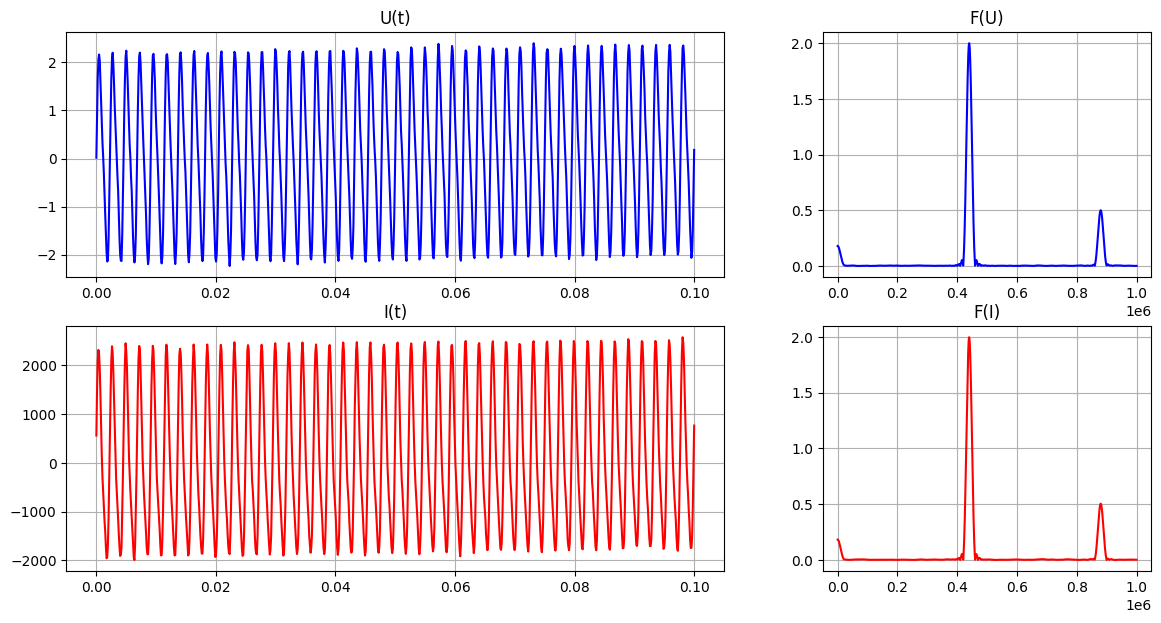

In [4]:
F,V = md.get_spectrum3(t,U)

F_peak_calc = F[np.argmax(V)]
T=1/F_peak_calc

print(F_peak_calc)

T_counts=md.convert_to_counts(t,T)

window=len(I)

vw.show_I_U_2(t,I,U,0,window)

# Оценка качества для среднего по нескольким методам

In [5]:
def variate_order(t,signal1,signal2,F_peak_calc,delta,phase_method):
    i=[]
    middle_means=[]
    middle_modes=[]

    for order in range(1,15,1):
        t_f, U_f=phase_method(t,signal1,F_peak_calc,delta,order)
        t_f, I_f=phase_method(t,signal2,F_peak_calc,delta,order)
    
        time_hilbert, phase_hilbert=md.get_phase_hilbert(t_f, U_f, I_f, F_peak_calc)
        time_FFT, phase_FFT = md.get_phase_FFT(t_f,U_f, I_f, F_peak_calc, n_periods=20, overlap=0.5)
        time_lockin, phase_lockin = md.get_phase_lockin(t_f,U_f, I_f, F_peak_calc,5)
            
        mean, mode=md.get_mean_mode(phase_hilbert,phase_FFT,phase_lockin)
        middle_means.append(mean)
        middle_modes.append(mode)
        i.append(order)

    print("Fin")
    return i, middle_means,middle_modes


In [6]:
i=[]
middle_means=[]


i, middle_means_elliptic,middle_modes_elliptic= variate_order(t,U,I,F_peak_calc,100e3,md.filter_elliptic_bandpass)
i, middle_means_cheby1,middle_modes_cheby1= variate_order(t,U,I,F_peak_calc,100e3,md.filter_cheby1_bandpass)
i, middle_means_butter,middle_modes_butter= variate_order(t,U,I,F_peak_calc,100e3,md.filter_butter_bandpass)

Fin
Fin
Fin


In [7]:
middle_means_butter_deviation=np.subtract(middle_means_butter,phase_real)
middle_means_cheby1_deviation=np.subtract(middle_means_cheby1,phase_real)
middle_means_elliptic_deviation=np.subtract(middle_means_elliptic,phase_real)

middle_modes_butter_deviation=np.subtract(middle_modes_butter,phase_real)
middle_modes_cheby1_deviation=np.subtract(middle_modes_cheby1,phase_real)
middle_modes_elliptic_deviation=np.subtract(middle_modes_elliptic,phase_real)

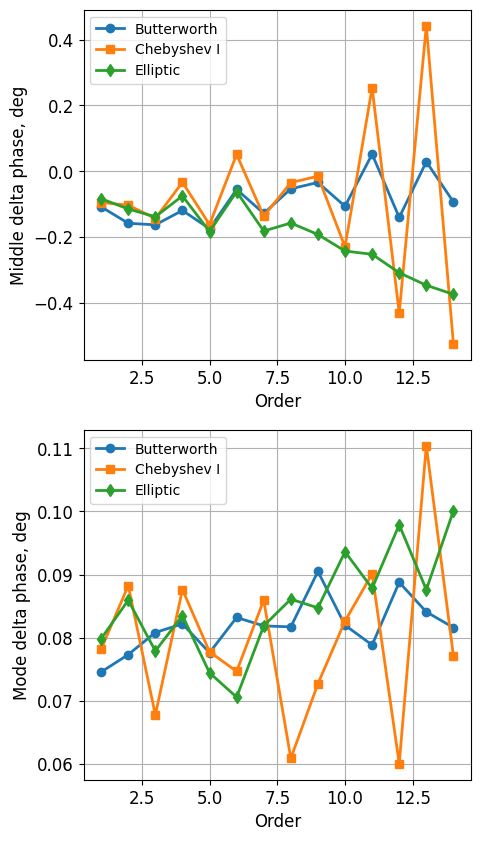

In [8]:
fig = plt.figure(figsize=(5, 10))
gs = fig.add_gridspec(2, 1)

front=12

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

ax1.plot(i, middle_means_butter_deviation, 'o-', label='Butterworth', linewidth=2)
ax1.plot(i, middle_means_cheby1_deviation, 's-', label='Chebyshev I', linewidth=2)
ax1.plot(i, middle_means_elliptic_deviation, 'd-', label='Elliptic', linewidth=2)
ax1.set_xlabel('Order', fontsize=front)
ax1.set_ylabel('Middle delta phase, deg', fontsize=front)
ax1.legend(fontsize=10)
ax1.tick_params(axis='both', labelsize=front)
ax1.grid(True)

ax2.plot(i, middle_modes_butter_deviation, 'o-', label='Butterworth', linewidth=2)
ax2.plot(i, middle_modes_cheby1_deviation, 's-', label='Chebyshev I', linewidth=2)
ax2.plot(i, middle_modes_elliptic_deviation, 'd-', label='Elliptic', linewidth=2)
ax2.set_xlabel('Order', fontsize=front)
ax2.set_ylabel('Mode delta phase, deg', fontsize=front)
ax2.legend(fontsize=10)
ax2.tick_params(axis='both', labelsize=front) 
ax2.grid(True)

In [9]:
def variate_delta(t, U, I, F_peak_calc, order, phase_method):
    i = []
    middle_means = []
    middle_modes=[]
    
    for delta in range(int(100e3), int(500e3), int(100e3)):  # преобразуем к int
        t_f, U_f = phase_method(t, U, F_peak_calc, delta, order)
        t_f, I_f = phase_method(t, I, F_peak_calc, delta, order)
    

        time_hilbert, phase_hilbert = md.get_phase_hilbert(t_f, U_f, I_f, fs)
        #time_FFT, phase_FFT = md.get_phase_FFT(t_f, U_f, I_f, F_peak_calc, n_periods=20, overlap=0.5)
        time_lockin, phase_lockin = md.get_phase_lockin(t_f, U_f, I_f, F_peak_calc, 5)
            
        mean, mode= md.get_mean_mode(phase_hilbert,phase_lockin)
        middle_means.append(mean)
        middle_modes.append(mode)
        i.append(delta)

    print("Fin")
    return i, middle_means,middle_modes

In [10]:
i=[]
middle_means=[]


i, middle_means_elliptic,middle_modes_elliptic=variate_delta(t,U,I,F_peak_calc,3,md.filter_elliptic_bandpass)
i, middle_means_cheby1,middle_modes_cheby1= variate_delta(t,U,I,F_peak_calc,3,md.filter_cheby1_bandpass)
i, middle_means_butter,middle_modes_butter= variate_delta(t,U,I,F_peak_calc,3,md.filter_butter_bandpass)

Fin
Fin
Fin


In [11]:
middle_means_butter_deviation=np.subtract(middle_means_butter,phase_real)
middle_means_cheby1_deviation=np.subtract(middle_means_cheby1,phase_real)
middle_means_elliptic_deviation=np.subtract(middle_means_elliptic,phase_real)

middle_modes_butter_deviation=np.subtract(middle_modes_butter,phase_real)
middle_modes_cheby1_deviation=np.subtract(middle_modes_cheby1,phase_real)
middle_modes_elliptic_deviation=np.subtract(middle_modes_elliptic,phase_real)

i=np.multiply(i,2)

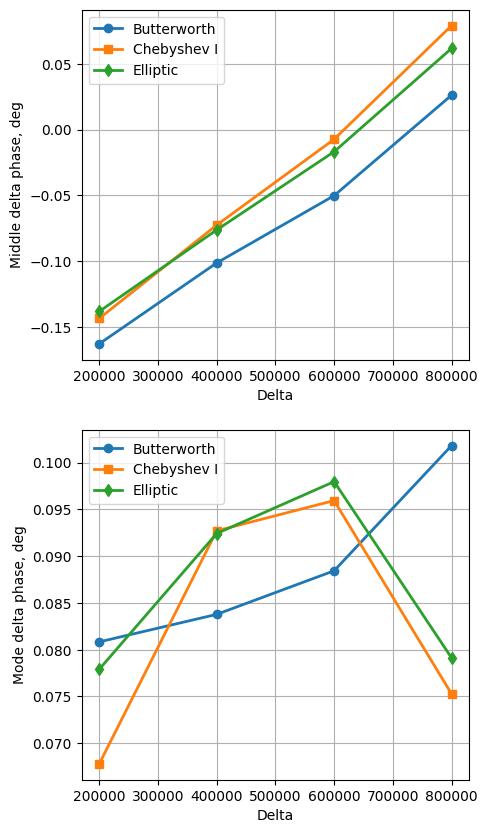

In [12]:
fig = plt.figure(figsize=(5, 10))
gs = fig.add_gridspec(2, 1)

front=10

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

ax1.plot(i, middle_means_butter_deviation, 'o-', label='Butterworth', linewidth=2)
ax1.plot(i, middle_means_cheby1_deviation, 's-', label='Chebyshev I', linewidth=2)
ax1.plot(i, middle_means_elliptic_deviation, 'd-', label='Elliptic', linewidth=2)
ax1.set_xlabel('Delta', fontsize=front)
ax1.set_ylabel('Middle delta phase, deg', fontsize=front)
ax1.legend(fontsize=10)
ax1.tick_params(axis='both', labelsize=front)
ax1.grid(True)

ax2.plot(i, middle_modes_butter_deviation, 'o-', label='Butterworth', linewidth=2)
ax2.plot(i, middle_modes_cheby1_deviation, 's-', label='Chebyshev I', linewidth=2)
ax2.plot(i, middle_modes_elliptic_deviation, 'd-', label='Elliptic', linewidth=2)
ax2.set_xlabel('Delta', fontsize=front)
ax2.set_ylabel('Mode delta phase, deg', fontsize=front)
ax2.legend(fontsize=10)
ax2.tick_params(axis='both', labelsize=front) 
ax2.grid(True)

# Оценка качества фильтра для каждого метода отдельно

In [33]:
def variate_order_solo_method(t,U,I,F_peak_calc,delta,filter_method,phase_method):
    i=[]
    middle_means=[]
    middle_modes=[]

    for order in range(1,15,1):
        t_f, U_f=filter_method(t,U,F_peak_calc,delta,order)
        t_f, I_f=filter_method(t,I,F_peak_calc,delta,order)
    
        time, phase=phase_method(t_f, U_f, I_f, F_peak_calc)

        mean, mode=md.get_mean_mode(phase)

        if (mean>360):
            mean=0
            print("error")

        if (mode>360):
            mode=0
            print("error")

        middle_means.append(mean)
        middle_modes.append(mode)
        i.append(order)
        print(i)
    
    return i, middle_means,middle_modes


In [34]:
phase_method=md.get_phase_xcorr2

In [35]:
i, phase_mean_elliptic,phase_mode_elliptic= variate_order_solo_method(t,U,I,F_peak_calc,100e3,md.filter_elliptic_bandpass,phase_method)
i, phase_mean_cheby1,phase_mode_cheby1=     variate_order_solo_method(t,U,I,F_peak_calc,100e3,md.filter_cheby1_bandpass,phase_method)
i, phase_mean_butter,phase_mode_butter=     variate_order_solo_method(t,U,I,F_peak_calc,100e3,md.filter_butter_bandpass,phase_method)

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 5, 

In [36]:
phase_mean_butter_deviation=np.subtract(phase_mean_butter,phase_real)
phase_mean_cheby1_deviation=np.subtract(phase_mean_cheby1,phase_real)
phase_mean_elliptic_deviation=np.subtract(phase_mean_elliptic,phase_real)

phase_mode_butter_deviation=np.subtract(phase_mode_butter,phase_real)
phase_mode_cheby1_deviation=np.subtract(phase_mode_cheby1,phase_real)
phase_mode_elliptic_deviation=np.subtract(phase_mode_elliptic,phase_real)

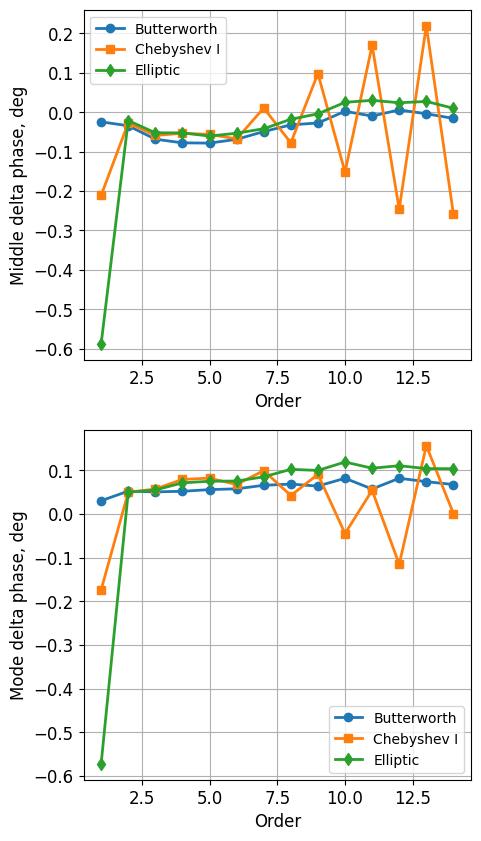

In [37]:
fig = plt.figure(figsize=(5, 10))
gs = fig.add_gridspec(2, 1)

front=12

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

ax1.plot(i, phase_mean_butter_deviation, 'o-', label='Butterworth', linewidth=2)
ax1.plot(i, phase_mean_cheby1_deviation, 's-', label='Chebyshev I', linewidth=2)
ax1.plot(i, phase_mean_elliptic_deviation, 'd-', label='Elliptic', linewidth=2)
ax1.set_xlabel('Order', fontsize=front)
ax1.set_ylabel('Middle delta phase, deg', fontsize=front)
ax1.legend(fontsize=10)
ax1.tick_params(axis='both', labelsize=front)
ax1.grid(True)

ax2.plot(i, phase_mode_butter_deviation, 'o-', label='Butterworth', linewidth=2)
ax2.plot(i, phase_mode_cheby1_deviation, 's-', label='Chebyshev I', linewidth=2)
ax2.plot(i, phase_mode_elliptic_deviation, 'd-', label='Elliptic', linewidth=2)
ax2.set_xlabel('Order', fontsize=front)
ax2.set_ylabel('Mode delta phase, deg', fontsize=front)
ax2.legend(fontsize=10)
ax2.tick_params(axis='both', labelsize=front) 
ax2.grid(True)